In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0

# Preliminaries

This chapter adapts the finite difference methods that we have studied so far to deal with cases where the problem constraints are given in the form of boundary conditions instead of initial values. This poses a difficulty as our iterative approach requires the solution at each step to be computed from the initial values. 

In this chapter we will consider two techniques that can be used to tackle boundary value problems with finite difference methods:

* The "shooting" method makes repeated use of the explicit solution methods we developed in the previous chapters, with a root-finding algorithm used to "guess" the missing initial values
* The matrix (linear algebra) method solves for all nodes of the system at once by setting up the finite difference scheme in the form of a system of algebraic equations to be solved simultaneously.

## About the problem 

The term "boundary value problem" (BVP) refers to cases where the solution constraints for a differential equation are specified at the boundaries of the independent variable domain. This is in contrast to an IVP where all constraints are imposed at the same "initial" value of the independent variable.

An example is the steady state equation for heat transer along a one-dimensional rod of length $L$, which is given by:

\begin{equation}
T^{\prime\prime}(x)=0, \qquad T(0)=a, \quad T(L)=b.
\end{equation}

The boundary conditions here impose the temperature at each end of the rod. The solution exhibits a constant temperature gradient:

\begin{equation}
\frac{T-a}{x}=\frac{b-a}{L}.
\end{equation}

Unlike IVPs, a boundary value problem (BVP) may have no solutions or infinitely many solutions. For example, the following problem is satisfied by $y=A\sin(x)$ for all values of the constant $A$ :

\begin{equation}
y^{\prime\prime}+y=0, \qquad y(0)=y(2\pi)=0.
\end{equation}

```{note}
To solve a boundary value problem numerically, it needs to be well-defined, with a unique solution. The problem given in {numref}`cauchy_example` is not straightforward to define as a boundary value problem because its general solution decays as $t\to\infty$ for all initial conditions:
\begin{equation*}
x = e^{-t}(A\cos(3t)+B\sin(3t)),
\end{equation*}
```

BVPs are also more tricky to attack by finite difference method, since information is communicated through the solution domain from *both* boundaries. For example, consider the manner in which the solution profile of the heated/cooled rod is influenced by the temperature at both ends of the domain. This prevents us from easily constructing a solution by forward stepping.


### Discretisation 

Before we go on to introduce these methods, we first revisit our method for discretising the domain. Up to now we have found it convenient to use `np.arange`, which allows us to set the step size $h$. However, if we do not choose a step size that accurately subdivides the domain, we will "miss" the endpoint where the boundary condition is to be imposed.

We can ensure that the right-hand boundary is included in the discretised domain by using `np.linspace`. The relationship between the number of steps $n$ and the step size $h$ on an interval $[a,b]$ is given by 

\begin{equation}
h = \frac{b-a}{n-1}
\end{equation}

Therefore if we want to subdivide an interval with an approximate step size $h$, we can use a method like follows:

In [2]:
def discretise(a,b,h_appr):
    n=int(np.ceil((b-a)/h_appr) +1) #steps required
    t=np.linspace(a,b,n)            #discretised domain
    h=t[1]-t[0]                     #computed step size
    return t,h

## Shooting method

The basic idea behind the shooting method is to "guess" the intial value required to implement an explicit forward-stepping technique. The solution can be compared to the boundary condition to evaluate how good the guess was. The guess can be repeatedly modified using a root-finding technique to obtain a value which works.

An illustration of the rule is provided below for the case of a second order derivative scalar problem, involving dependent variable $x$ with boundary values $\alpha$ and $\beta$ :

<br>

```{image} ../images/shooting_idea.png
:alt: secant
:align: center
:scale: 80%
```
<br>

The algorithm is fairly straightforward to implement. However, it does not generalise well to solve PDE problems.

### Example: Blasius boundary layer 

To demonstrate the shooting technique, we will consider the following third order problem, which describes the velocity profile $f^{\prime}(y)$ that forms over a flat plate in an oncoming stream of constant velocity fluid.

\begin{equation}
f^{\prime\prime\prime}(y)+f(y)f^{\prime\prime}(y)=0, \quad f(0)=f^{\prime}(0)=0, \quad \lim_{y\to\infty}f^{\prime}(y)=1
\end{equation}

```{note}
In all of the previous problems we have used variables $(t,x)$, but here we are using $(y,f).$ Try not to get confused by the change of notation! 
```

Taking $\underline{u}=(u,v,w)$ where $u=f(y)$, $v=f^{\prime}(y)$, $w=f^{\prime\prime}(y)$ allows us to rewrite the problem as a first order system:

\begin{equation}
\frac{\mathrm{d}\underline{u}}{\mathrm{d}y}=F(y,\underline{u}), \qquad 
F(y,\underline{u})=\begin{bmatrix}v\\w\\-uw\end{bmatrix}, \qquad \underline{u}(0)=\begin{bmatrix}0\\0\\c\end{bmatrix}.
\end{equation}

The value $c$ needs to be chosen such that $v_{\infty}=1$. In the following application we assume that the solution has converged by $y~10$, and take this to represent the domain boundary.

In [3]:
# Define the first order ODE system
def dUdy(y,U):
  u,v,w=U
  return np.array([v,w,-u*w])

y,h=discretise(0,10,0.01)  #Domain (taking inf ~=10)
U=np.empty((len(y),3));    #Two-column solution array
U[0,0]=0                   #Initial condition u0=f0
U[0,1]=0                   #Initial condiiton v0=f0'

We'll use the modified Euler method, which is an explicit two stage method. It is based on the trapezoidal rule, with the explicit Euler method used to esimate $U_{k+1}$ in the first stage:

\begin{align}
\bar{U}_{k+1}&=U_k+hF(y_k,U_k)\\
U_{k+1}&=U_k+\frac{h}{2}(F(y_k,U_k)+F(y_{k+1},\bar{U}_{k+1}))
\end{align}

The following function applies the method for a given initial condition $c$ and computes the error in the estimate for $v_{\infty}$

In [4]:
def shoot(c):
  U[0,2]=c                      #Guess for w0=f0''
  for k in range(0,len(y)-1):
    Fk=dUdy(y[k],U[k])          #F(t_k,U_k)
    Fe=dUdy(y[k+1],U[k]+h*Fk)   #F(t_{k+1},U_k+hF_k)
    U[k+1]=U[k]+h/2*(Fk+Fe)     #modified Euler
  return np.abs(U[-1,1]-1)      #error in f'(inf)

Applying the method with initial guess $f^{\prime\prime}(0)=0.3$ and plotting the result for the Blaius profile $f^{\prime}(y)$ :

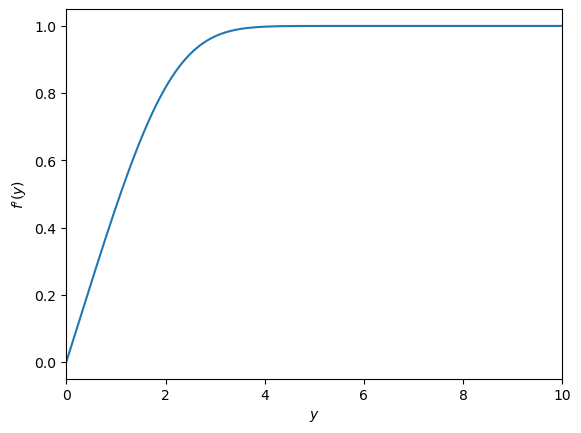

In [5]:
# Find the root for f0''
from scipy.optimize import fsolve 
res = fsolve(shoot, 0.3)

plt.plot(y,U[:,1])
plt.xlabel('$y$')
plt.ylabel('$f^{\prime}(y)$')
plt.show()

(dirode)=
## Matrix method 

The shooting method can be an attractive and effective way to solve a BVP that involves a single independent variable. However, it is difficult to see how it might be adapted to solve a partial BVP. 

The method that we will introduce next can be used for both ODEs and PDEs. It involves labelling every node in the discretised solution domain and using the finite difference rules to write down their governing algebraic equations. Efficient linear algebra routines can be used to simultaneously solve these systems.

### Example: 2nd order ODE

We will start by demonstating the technique for the following second order BVP:

\begin{equation*}
\ddot{x}+\dot{x}-6x=0, \qquad x(0)=1,\quad x(1)=2.
\end{equation*}

Application of the midpoint difference rules gives the a system of linear equations: 

\begin{equation}
(1-h/2)x_{k-1}-(2+6h^2)x_k+(1+h/2)x_{k+1}=0.
\end{equation}

We can write this as a matrix system involving variables $x_0,\dots x_n$. The fixed value boundary conditions can be implemented in the first and last rows and we obtain the following matrix system to solve.

```{math}
:label: dirmatr1
\left[\begin{array}{cccccc}
1 &0 & 0 & 0 & \dots & 0\\
1-h/2 & -(2+6h^2) & 1+h/2 & 0 & \ddots &\vdots\\
0 & 1-h/2 & -(2+6h^2) & 1+h/2 & \ddots&\vdots\\
\vdots& \ddots & \ddots &\ddots &\ddots & 0\\
0 & \ddots & 0& 1-h/2 & -(2+6h^2) & 1+h/2\\
0 &\dots & 0 & 0 & 0 & 1\end{array}\right]
\left[\begin{array}{cc} x_0\phantom{\vdots}&\\y_1&\phantom{\vdots}\\x_2\phantom{\vdots}&\\ \vdots&\\x_{n-1}\\x_n\end{array}\right]=\left[\begin{array}{cc}1&\phantom{\vdots}\\0&\phantom{\vdots}\\0&\phantom{\vdots}\\\vdots&\\0\\2\end{array}\right]
```

The $(n+1)\times(n+1)$ tri-diagonal matrix has diagonal coefficients $\biggr[1-h/2,-(2+6h^2),1+h/2\biggr]$, except for the first and last rows which are used to implement the boundary conditions.


You can solve the simultaneous system in Python by using the `solve` function from numpy's linear algebra module (`linalg`). An implementation is shown below, in which matrix $A$ is constructed using `numpy.diag`. This function  can be used to create an array with the given data on the $k$th diagonal and zeros everywhere else:

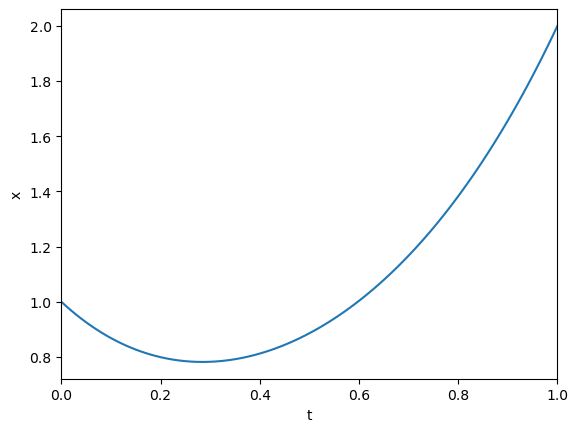

In [6]:
from numpy import diag,ones,zeros,linalg,arange

# Define the nodes
t,h=discretise(0,1,0.01)
#---------------------------------------------------------------
# Construct tridiagonal matrix A and vector b
# Initially we ignore the BCs:

c1,c2,c3= [1-h/2, -2-6*h**2, 1+h/2]
n=len(t)

A = diag([c1]*(n-1),k=-1) + \
    diag([c2]*n,    k=0)  + \
    diag([c3]*(n-1),k=1)

b = zeros((n,1))

# Now enforce the BCs: 
A[0, [ 0, 1, 2]]=[1,0,0]; b[0 ] = 1  # x(0)
A[-1,[-3,-2,-1]]=[0,0,1]; b[-1] = 2  # x(1)

#---------------------------------------------------------------
# Solve the matrix system numerically
x= linalg.solve(A,b)

plt.plot(t,x)
plt.xlabel('t'); plt.ylabel('x')
plt.show()

```{exercise}
Other techniques could be used to create the tridiagonal matrix. Can you do it with a loop-based technique?
```

````{toggle}
Here is an example of how it could be done:

```{code}
M = zeros([n,n])
for k in range(1,n-1):
  M[k,[k-1,k,k+1]]=[c1,c2,c3]
M[0,0]=1; M[-1,-1]=1
np.array_equal(A,M) #test
```
````

### For Python gurus

The matrix calculations above are resource-intensive. The size of the coefficient matrix is quadratically dependent on the number of data points, and numerically solving the system requires a very large number of "flops" (floating point operations). I tried decreasing the step size to `h=0.0001` and the calculation took more than 10 seconds on my fairly standard three-year-old desktop computer.

However, you may notice that matrix $A$ in the above example is relatively "sparse". Only three of the digaonals contain non-zero elements. Instead of recoding every element, we may therefore want to record only the indexed locations and values of the non-zero elements. This type of representation may require less memory to store, and can allow use of highly efficient algorithms designed for sparse matrices.

An example implementation is given below. This code took less than two seconds to run on an fairly standard desktop computer and less than 3Mb of memory were required to store matrix $A$. The equivalent "dense" representation for this step size would have required around 75 Gigabytes!

Compuation time (s) :  1.0492944717407227
Memory (Mb) :  2.3999919999999997


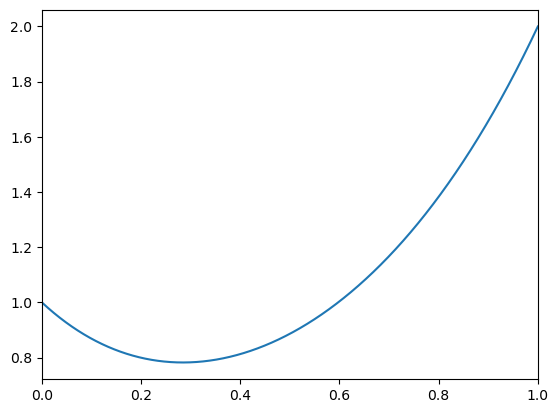

In [7]:
import time
# Define the nodes
t,h=discretise(0,1,0.00001); n=len(t)

from scipy import sparse
import scipy.sparse.linalg

T = time.time()
A = sparse.lil_matrix((n, n))
b = sparse.lil_matrix((n, 1))
c1,c2,c3= [1-h/2, -2-6*h**2, 1+h/2]
A.setdiag([c1]*(n-1),k=-1)
A.setdiag([c2]*(n),  k=0 )
A.setdiag([c3]*(n-1),k=1 )
A[0, [ 0, 1, 2]]=[1,0,0]; b[0 ] = 1  # x(0)
A[-1,[-3,-2,-1]]=[0,0,1]; b[-1] = 2  # x(1)
A = A.tocsr(); b=b.tocsr()

x=sparse.linalg.spsolve(A,b)
print('Compuation time (s) : ',time.time()-T)
print('Memory (Mb) : ',(A.data.nbytes)*1e-6)    #size of A in Mb

plt.plot(t,x)
plt.show()


(matrix-cauchy)=
## Ghost points 

Some BVPs requre a derivative condtion to be imposed on one or both boundaries. Solving these problems will require the introduction of ghost points, as we did in the second derivative problems in the last chapter. 

The ghost point variables can be included in our matrix method, and these points can be removed from the solution array at the end.

As an example, consider the following matrix representation of the problem given in {numref}`cauchy_example` :

\begin{equation}
\left[\begin{array}{c|ccccc}-1 &0 &1 & 0 & \dots & 0&\\\hline0 &1 &0 & 0 & \ddots &\vdots\\1-h & -2+10h^2 & 1+h & 0 & \ddots &\vdots\\0 & 1-h & -2+10h^2 & 1+h & \ddots&\vdots\\\vdots& \vdots & \ddots &\ddots &\ddots & 0\\0 & \dots & 0& 1-h & -2+10h^2 & 1+h\end{array}\right]\left[\begin{array}{cc}x_{-1}&\\\hline x_0\vphantom{\ddots}&\\x_1&\vphantom{\ddots}\\x_2\vphantom{\ddots}&\\ \vdots\vphantom{\ddots}&\\x_N\vphantom{h^2}\end{array}\right]=\left[\begin{array}{cc}-2h&\\\hline1&\vphantom{\ddots}\\0&\vphantom{\ddots}\\0&\vphantom{\ddots}\\\vdots\vphantom{\ddots}&\\0\vphantom{h^2}\end{array}\right]
\end{equation}

<br>


```{admonition} Note
:class: theorem
The reason the coefficients are not centred on the main diagonal is because the first two rows are used to implement the boundary conditions.
```

If you are struggling to understand where the result comes from, write down the some of the simultaneous equations that you get by multipliying out the matrix product.

```{toggle}
The first row implements the derivative boundary condition: <br>
$\qquad \qquad -x_{-1}+x_{1}=-2h$

The second row implements the fixed boundary condition: <br>
$\qquad \qquad x_0=1$

The third row implements the central difference formula: <br> 
$\qquad \qquad (1-h)x_{-1}+(-2+10h^2)x_0+(1+h)x_1=0$

etc.

___________
```



The result obtained by numerically solving this system is shown below.

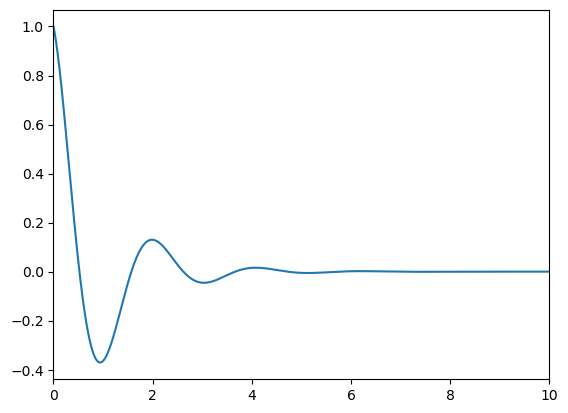

In [8]:
# Define the nodes
t,h=discretise(0,10,0.001); n=len(t)


A = sparse.lil_matrix((n+1, n+1))
b = sparse.lil_matrix((n+1, 1))
c1,c2,c3= [1-h, -2+10*h**2, 1+h]
A.setdiag([c1]*(n-1),k=-2)
A.setdiag([c2]*(n),  k=-1 )
A.setdiag([c3]*(n+1),k=0 )
A[0,[0,1,2]] = [-1,0,1]; b[0 ] = -2*h  # x'(0)
A[1, [0,1,2]] = [0,1,0]; b[1] = 1  # x(0)
A = A.tocsr(); b=b.tocsr()

x=sparse.linalg.spsolve(A,b)
x = x[1:]                       #remove ghost point

plt.plot(t,x)
plt.show()

```{note}
It should be noted that the problem given in {numref}`cauchy_example` is an IVP and therefore can be solved by iterative methods. We would not use a (less efficient) matrix method for such a problem! However, this example was used to illustrate how a derivative condition at a boundary can be implemented.
```

## Chapter exercises

**Question 1**<br>

The second derivative problem for the logistic function that we saw in {eq}`ord2logist` could be written as a BVP by imposing the following conditions:

\begin{equation}x(0)=C/2, \quad \lim_{t\to\infty}x = C.\end{equation}

How easy do you think this problem would be to solve numerically, given what you know about the second derivative equation from the previous section?

**Question 2**<br>
Apply the matrix solution approach to solve following equation using a central finite difference scheme
```{math}
:label: cdiffsin
u^{\prime\prime}(x)=\sin(2\pi x), \qquad u(0)=0, \quad u(1)=0
```


**Question 3**<br>
The image below shows a cross-section of pipe insulation, which is subjected to temperatures $\phi=500K$ on the inner boundary and $\phi=300K$ on the outer boundary. The radial and axial directions are denoted by $r,\theta$, respectively.

<br>

```{image} ../images/lagging.png
:alt: secant
:align: center
:scale: 40%
```
<br>

Due to axial symmetry of the problem, the governing two-dimensional heat equation $\nabla^2\phi=0$ for this problem can be reduced to
```{math}
:label: heateqn
\frac{\partial^2\phi}{\partial r^2}+\frac{1}{r}\frac{\partial \phi}{\partial r}=0.
```

Express equation {eq}`heateqn` in finite difference form, using a central difference scheme, and use a matrix method to solve for $r\in[0.05,0.10]$.

Graphically compare your answer to the analytic solution, which is given by
\begin{equation*}\phi = 200\frac{\ln(0.10)-\ln(r)}{\ln(2)} +300.\end{equation*}